In [27]:
import re
import os
import os.path as op
from pprint import pprint
from osl import utils
from osl import source_recon
import numpy as np
import coinsmeg_data as coinsmeg
import open3d
from IPython.display import HTML, display

## Compute Surfaces, Coregistration and Forward Modelling

### Compute surfaces

The first thing we need to do is to use the structural image to compute the head and brain surfaces in Native and MNI space using *rhino.compute_surfaces*. The head and brain surfaces will be used later  for carrying out the coregistration and forward modelling.

For now, we'll do this for one subject.

The inputs we need to provide are for the first subject are:

* *smri_file* - the full path to the structural MRI niftii file
* *recon_dir* - the full path to the directory that will contain the subject directories that RHINO will output
* *subject* - the name of the subject directory that RHINO will output
* *include_nose* - a boolean flag indicating whether or not to extract a head surface from the structural MRI that includes the nose. It your structural MRI includes the nose AND you have acquired polhemus headshape points that include the nose, then it is recommend to set this flag to True

In [28]:
sub = coinsmeg.sub_num2str(17) #  function sub_num2str converts a numerical subject identifier into a string formatted as sub-XX

# Directories

preproc_dir = op.join(coinsmeg.DERIVATIVES_DIR, "preprocessed")
recon_dir = op.join(coinsmeg.DERIVATIVES_DIR, "recon")

print(preproc_dir)
anat_dir = coinsmeg.get_sub_anat_dir(sub)
smri_file = f"{anat_dir}/{sub}_T1w.nii"

# There are multiple runs for each subject. We will first fetch all data using an OSL utility
def find_fif_files(data_dir, subject, run=None):
    # Define the base search pattern
    base_pattern = f"{subject}_ses-2-meg_task-coinsmeg_run-"
    
    # If run is specified, use the exact pattern
    if run:
        search_pattern = f"{base_pattern}{run}_meg_transsss_preproc_raw"
    else:
        # If run is not specified, use a wildcard pattern
        search_pattern = f"{base_pattern}.*_meg_transsss_preproc_raw"

    print(search_pattern)
    # List to store paths of matching files
    matching_files = []

    # Walk through the directory recursively
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith(".fif"):
                # Match using regex to account for wildcard if run is not specified
                if re.search(search_pattern, file):
                    matching_files.append(os.path.join(root, file))
    
    return matching_files

fif_files = find_fif_files(preproc_dir, sub)


print('Structural files:')
pprint(smri_file)

print('fif files:')
pprint(fif_files)

/ohba/pi/lhunt/datasets/coins-meg_data/derivatives/preprocessed
sub-17_ses-2-meg_task-coinsmeg_run-.*_meg_transsss_preproc_raw
Structural files:
'/ohba/pi/lhunt/datasets/coins-meg_data/sub-17/ses-3-structural/anat/sub-17_T1w.nii'
fif files:
['/ohba/pi/lhunt/datasets/coins-meg_data/derivatives/preprocessed/sub-17_ses-2-meg_task-coinsmeg_run-4_meg_transsss/sub-17_ses-2-meg_task-coinsmeg_run-4_meg_transsss_preproc_raw.fif',
 '/ohba/pi/lhunt/datasets/coins-meg_data/derivatives/preprocessed/sub-17_ses-2-meg_task-coinsmeg_run-1_meg_transsss/sub-17_ses-2-meg_task-coinsmeg_run-1_meg_transsss_preproc_raw.fif',
 '/ohba/pi/lhunt/datasets/coins-meg_data/derivatives/preprocessed/sub-17_ses-2-meg_task-coinsmeg_run-2_meg_transsss/sub-17_ses-2-meg_task-coinsmeg_run-2_meg_transsss_preproc_raw.fif',
 '/ohba/pi/lhunt/datasets/coins-meg_data/derivatives/preprocessed/sub-17_ses-2-meg_task-coinsmeg_run-3_meg_transsss/sub-17_ses-2-meg_task-coinsmeg_run-3_meg_transsss_preproc_raw.fif']


In [29]:
source_recon.rhino.compute_surfaces(
    smri_file,
    recon_dir,
    sub,
    include_nose=True,
)

 *** OSL RHINO: USING PREVIOUSLY COMPUTED SURFACES ***
 Surfaces directory: /ohba/pi/lhunt/datasets/coins-meg_data/derivatives/recon/sub-17/rhino/surfaces
 include_nose=True


True

We can now view the result using *fsleyes*. Note that *fsleyes* can sometimes take a few moments to open.

CHECK: in fsleyes that:

* The surfaces have been extracted properly compared with the structural
* The nose is included in the scalp surface, if that was requested with the *include_nose* option above

In [177]:
source_recon.rhino.surfaces_display(recon_dir, sub)

### Get Polhemus-space coordinates

We need to now provide the coordinates for the nasion, LPA, RPA, and headshape points in Polhemus (head) space, in millimetres. The polhemus coordinates need to be extracted from the MEG fif file; it is stored in the info['dig'] attribute of an MNE Raw object.

In [31]:
import mne
print(fif_files)
raw = mne.io.read_raw_fif(fif_files[1], preload=False) # sub 17, run 1

# Access the digitization data (Polhemus data)
dig = raw.info['dig'] 

['/ohba/pi/lhunt/datasets/coins-meg_data/derivatives/preprocessed/sub-17_ses-2-meg_task-coinsmeg_run-4_meg_transsss/sub-17_ses-2-meg_task-coinsmeg_run-4_meg_transsss_preproc_raw.fif', '/ohba/pi/lhunt/datasets/coins-meg_data/derivatives/preprocessed/sub-17_ses-2-meg_task-coinsmeg_run-1_meg_transsss/sub-17_ses-2-meg_task-coinsmeg_run-1_meg_transsss_preproc_raw.fif', '/ohba/pi/lhunt/datasets/coins-meg_data/derivatives/preprocessed/sub-17_ses-2-meg_task-coinsmeg_run-2_meg_transsss/sub-17_ses-2-meg_task-coinsmeg_run-2_meg_transsss_preproc_raw.fif', '/ohba/pi/lhunt/datasets/coins-meg_data/derivatives/preprocessed/sub-17_ses-2-meg_task-coinsmeg_run-3_meg_transsss/sub-17_ses-2-meg_task-coinsmeg_run-3_meg_transsss_preproc_raw.fif']


In [32]:
fif_files[1]

'/ohba/pi/lhunt/datasets/coins-meg_data/derivatives/preprocessed/sub-17_ses-2-meg_task-coinsmeg_run-1_meg_transsss/sub-17_ses-2-meg_task-coinsmeg_run-1_meg_transsss_preproc_raw.fif'

In [33]:
polhemus_dir = op.join(recon_dir, sub, "polhemus")
# make directory if it doesn't yet exist
os.makedirs(polhemus_dir, exist_ok=True)

In [34]:
from osl.source_recon.rhino.polhemus import extract_polhemus_from_info

extract_polhemus_from_info(
    fif_file = fif_files[1],
    headshape_outfile=op.join(polhemus_dir, "polhemus_headshape.txt"),
    nasion_outfile=op.join(polhemus_dir, "polhemus_nasion.txt"),
    rpa_outfile=op.join(polhemus_dir, "polhemus_rpa.txt"),
    lpa_outfile=op.join(polhemus_dir, "polhemus_lpa.txt")
)

# recall that our maxfiltering options were
# f"--maxpath /neuro/bin/util/maxfilter --mode multistage --scanner Neo --tsss --headpos --movecomp --trans {trans_file}",)
        #  the maxfilter aligns all runs of a participant so that the head position is the same within each participant


 Extracting polhemus from fif info
 saved: /ohba/pi/lhunt/datasets/coins-meg_data/derivatives/recon/sub-17/polhemus/polhemus_nasion.txt
 saved: /ohba/pi/lhunt/datasets/coins-meg_data/derivatives/recon/sub-17/polhemus/polhemus_rpa.txt
 saved: /ohba/pi/lhunt/datasets/coins-meg_data/derivatives/recon/sub-17/polhemus/polhemus_lpa.txt
 saved: /ohba/pi/lhunt/datasets/coins-meg_data/derivatives/recon/sub-17/polhemus/polhemus_headshape.txt


### Run the coregistration

In [35]:
def copy_polhemus_files(recon_dir, subject, preproc_file, smri_file, logger):
    polhemus_headshape = np.loadtxt(op.join(polhemus_dir, 'polhemus_headshape.txt'))
    polhemus_nasion = np.loadtxt(op.join(polhemus_dir, 'polhemus_nasion.txt'))
    polhemus_rpa = np.loadtxt(op.join(polhemus_dir, 'polhemus_rpa.txt'))
    polhemus_lpa = np.loadtxt(op.join(polhemus_dir, 'polhemus_lpa.txt'))
    
    #  Get coreg filenames
    filenames = source_recon.rhino.get_coreg_filenames(recon_dir, subject)

    # Save
    np.savetxt(filenames["polhemus_nasion_file"], polhemus_nasion)
    np.savetxt(filenames["polhemus_rpa_file"], polhemus_rpa)
    np.savetxt(filenames["polhemus_lpa_file"], polhemus_lpa)
    np.savetxt(filenames["polhemus_headshape_file"], polhemus_headshape)

copy_polhemus_files(recon_dir, sub, [], [], [])

sub1_polhemus_nasion = op.join(recon_dir, sub, 'rhino/coreg/polhemus_nasion.txt')
print(sub1_polhemus_nasion)
#print(f"E.g., the coordinates for the nasion for subject {sub} in Polhemus space are \n", os.system('more {}'.format(sub1_polhemus_nasion)))

/ohba/pi/lhunt/datasets/coins-meg_data/derivatives/recon/sub-17/rhino/coreg/polhemus_nasion.txt


In [36]:
#extract_fiducials_from_fif below doesn't work
'''
config = """
    source_recon:
    - extract_fiducials_from_fif: true
    - compute_surfaces:
        include_nose: true
    - coregister:
        use_nose: true
        use_headshape: true
    - forward_model:
        model: Single Layer
        gridstep: 10
"""

source_recon.run_src_batch(
    config,
    outdir=recon_dir,
    subjects=[sub],
    preproc_files=fif_files[1],
    smri_files=smri_file,
)
'''

'\nconfig = """\n    source_recon:\n    - extract_fiducials_from_fif: true\n    - compute_surfaces:\n        include_nose: true\n    - coregister:\n        use_nose: true\n        use_headshape: true\n    - forward_model:\n        model: Single Layer\n        gridstep: 10\n"""\n\nsource_recon.run_src_batch(\n    config,\n    outdir=recon_dir,\n    subjects=[sub],\n    preproc_files=fif_files[1],\n    smri_files=smri_file,\n)\n'

Now run the coreg!

In [183]:
source_recon.rhino.coreg(
    fif_files[1], # full path to the MNE raw fif file
    recon_dir, # full path to the directory that contains the subject directories RHINO outputs
    sub, # the name of the subject directories RHINO outputs to
    use_headshape=True,     #use the headshape points to refine the coregistration?
    use_nose=True, # use the nose headshape points to refine the coregistration?
)

 *** RUNNING OSL RHINO COREGISTRATION ***
 The MRI-derived nose is going to be used to aid coreg.
 Please ensure that rhino.compute_surfaces was run with include_nose=True.
 Please ensure that the polhemus headshape points include the nose.
 loading: /ohba/pi/lhunt/datasets/coins-meg_data/derivatives/recon/sub-17/rhino/coreg/polhemus_headshape.txt
 loading: /ohba/pi/lhunt/datasets/coins-meg_data/derivatives/recon/sub-17/rhino/coreg/polhemus_nasion.txt
 loading: /ohba/pi/lhunt/datasets/coins-meg_data/derivatives/recon/sub-17/rhino/coreg/polhemus_rpa.txt
 loading: /ohba/pi/lhunt/datasets/coins-meg_data/derivatives/recon/sub-17/rhino/coreg/polhemus_lpa.txt
 Using known MNI fiducials
 Running ICP...
 ICP found better xform, error=2.0544195554990488
 rhino.coreg_display("/ohba/pi/lhunt/datasets/coins-meg_data/derivatives/recon", "sub-17") can be used to check the result
 *** OSL RHINO COREGISTRATION COMPLETE ***


In [184]:
# now view result
source_recon.rhino.coreg_display("/ohba/pi/lhunt/datasets/coins-meg_data/derivatives/recon", "sub-17")

Creating surface mesh for /ohba/pi/lhunt/datasets/coins-meg_data/derivatives/recon/sub-17/rhino/coreg/scaled_outskin_plus_nose_mesh.nii.gz .....


The coregistration result is shown in MEG (device) space (in mm).

* Grey disks - MEG sensors
* Blue arrows - MEG sensor orientations
* Yellow diamonds - MRI-derived fiducial locations
* Pink spheres - Polhemus-derived fiducial locations
* Green surface - Whole head scalp extraction
* Red spheres - Polhemus-derived headshape points

A good coregistration shows:

* MRI fiducials (yellow diamonds) in appropriate positions on the scalp
* Polhemus-derived fiducial locations (pink spheres) in appropriate positions on the scalp 
* Good correspondence between the headshape points (red spheres) and the scalp
* The scalp appropriately inside the sensors, and with a sensible orientation.

If you have a bad co-registration:

* Go back and check that the compute_surfaces has worked well using fsleyes (see above).
* Check for misleading or erroneous headshape points (red spheres) and remove them. See the <a href="https://osf.io/nr9su" target="_top">Deleting Headshape Points</a> tutorial for how to delete headshape points.

* Check that the settings for using the nose are compatible with the available MRI and headshape points
* The subject in question may need to be omitted from the ensuing analysis.

### Compute forward model

We can now compute the forward model (the lead fields) given we can now put the MEG sensors and head / brain surfaces in the same coordinate system. We do this by running *rhino.forward_model*. Note that this is mostly just a wrapper call for a standard MNE function.

Here we are modelling the brain/head using 'Single Layer', which corresponds to just modelling the inner skull surface, which is the standard thing to do in MEG forward modelling.

Lead fields will be computed for a regularly space dipole grid, with a spacing given by the passed in argument *gridstep*. The dipole grid is confined to be inside the brain mask as computed by *rhino.compute_surfaces*.

In [185]:
gridstep = 10
source_recon.rhino.forward_model(
    recon_dir,
    sub,
    model="Single Layer",
    gridstep=gridstep,
)

 *** RUNNING OSL RHINO FORWARD MODEL ***
 Using bet_inskull_surf_file for single shell surface
 *** OSL RHINO FORWARD MODEL COMPLETE ***


Now view the results. Note that small black points inside the brain show the locations of dipoles that the leadfields have been computed for.

In [186]:
source_recon.rhino.bem_display(
    recon_dir,
    sub,
    display_outskin_with_nose=False,
    display_sensors=True,
    plot_type="surf",
    filename='./coreg_display.html',
)

 BEM surface: number of dipoles = 1303


/home/ali/anaconda3/envs/osl/lib/python3.8/site-packages/pyvista/plotting/renderer.py:536: UserWarning: VTK compiled with OSMesa does not properly support FXAA anti-aliasing and SSAA will be used instead.
  warnings.warn(


 saving ./coreg_display.html


In [187]:
# Display HTML content in notebook
display(HTML('./coreg_display.html'))

We now have a *forward_model_file* stored in the rhino directory for this subject.
    
This file contains the leadfields that map from source to sensor space, and which are used to do source reconstruction.


In [188]:
from mne import read_forward_solution

# load forward solution
fwd_fname = op.join(recon_dir, sub, "rhino", "model-fwd.fif") 
# tutorial said source_recon.rhino.get_coreg_filenames(recon_dir, subjects[0])["forward_model_file"]
# but this did not return a match for "forward_model_file"
print(fwd_fname)

/ohba/pi/lhunt/datasets/coins-meg_data/derivatives/recon/sub-17/rhino/model-fwd.fif


In [189]:
fwd = read_forward_solution(fwd_fname)
leadfield = fwd["sol"]["data"]
print("Leadfield size : %d sensors x %d dipoles" % leadfield.shape)

Leadfield size : 306 sensors x 3909 dipoles


#### Batched RHINO: Does all the above steps in one (not really working?)

In [190]:
'''
## Batched RHINO: Does all the above steps in one
config = """
    source_recon:
        - copy_polhemus_files: {}
        - compute_surfaces:
            include_nose: true
        - coregister:
            use_nose: true
            use_headshape: true
        - forward_model:
            model: Single Layer
            gridstep: 10
    """
# create directory for the report if it doesn't exist
reportdir=op.join(recon_dir, sub, "report")
os.makedirs(reportdir, exist_ok=True)
'''

In [191]:
'''
config = """
source_recon:
- extract_fiducials_from_fif: {}
- compute_surfaces:
    include_nose: true
- coregister:
    use_nose: true
    use_headshape: true
- forward_model:
    model: Single Layer
"""
'''

In [192]:
'''
source_recon.run_src_batch(
    config,
    outdir=recon_dir,
    subjects=[sub],
    preproc_files=fif_files[1], # first run
    smri_files=smri_file,
    gen_report=True,
    reportdir=reportdir
)
'''

 OSL osl_logger: handler 'console' level set to 'INFO'
 logging to file: /ohba/pi/lhunt/datasets/coins-meg_data/derivatives/recon/logs/osl_batch.log
 Starting OSL Batch Source Reconstruction
 Running config
 {'source_recon': [{'extract_fiducials_from_fif': {}},
                  {'compute_surfaces': {'include_nose': True}},
                  {'coregister': {'use_headshape': True, 'use_nose': True}},
                  {'forward_model': {'model': 'Single Layer'}}]}
sub-17 : OSL osl_logger: handler 'console' level set to 'INFO'
sub-17 : logging to file: /ohba/pi/lhunt/datasets/coins-meg_data/derivatives/recon/logs/sub-17_src.log
sub-17 : 2024-09-05 11:35:10 : Starting OSL Processing
sub-17 : input : /ohba/pi/lhunt/datasets/coins-meg_data/derivatives/recon/sub-17
sub-17 : *********************************
sub-17 : * SOURCE RECONSTRUCTION FAILED! *
sub-17 : *********************************
sub-17 : extract_fiducials_from_fif : <function extract_fiducials_from_fif at 0x7fcee8269ee0>
sub-17 

/home/ali/Desktop/osl/osl/source_recon/batch.py:153: RuntimeWarning: Log entries will be appended to the file. Use overwrite=False to avoid this message in the future.
  mne.utils._logging.set_log_file(logfile)
  File "/home/ali/Desktop/osl/osl/source_recon/batch.py", line 199, in run_src_chain
    wrapped_func(
  File "/home/ali/Desktop/osl/osl/source_recon/batch.py", line 191, in wrapped_func
    args_with_defaults = args[-len(defaults):]


[False]

## Temporal Filtering

We temporally filter the data to focus on the oscillatory content that we are interest in. 

Here, we assume that we will be doing an evoked response (ERF) analysis on the epoched task data, and so we filter to the frequency range where the evoked response is typically contained, i.e. between 1 and 30 Hz.


In [193]:
fif_files

['/ohba/pi/lhunt/datasets/coins-meg_data/derivatives/preprocessed/sub-17_ses-2-meg_task-coinsmeg_run-4_meg_transsss/sub-17_ses-2-meg_task-coinsmeg_run-4_meg_transsss_preproc_raw.fif',
 '/ohba/pi/lhunt/datasets/coins-meg_data/derivatives/preprocessed/sub-17_ses-2-meg_task-coinsmeg_run-1_meg_transsss/sub-17_ses-2-meg_task-coinsmeg_run-1_meg_transsss_preproc_raw.fif',
 '/ohba/pi/lhunt/datasets/coins-meg_data/derivatives/preprocessed/sub-17_ses-2-meg_task-coinsmeg_run-2_meg_transsss/sub-17_ses-2-meg_task-coinsmeg_run-2_meg_transsss_preproc_raw.fif',
 '/ohba/pi/lhunt/datasets/coins-meg_data/derivatives/preprocessed/sub-17_ses-2-meg_task-coinsmeg_run-3_meg_transsss/sub-17_ses-2-meg_task-coinsmeg_run-3_meg_transsss_preproc_raw.fif']

In [194]:
import mne

chantypes = ["grad"] 

# Get and setup the data
data = mne.io.read_raw_fif(fif_files[1], preload=True)
data = data.pick(chantypes)

# Filter to the beta band
print("Temporal Filtering")
data = data.filter(
    l_freq=1,
    h_freq=30,
    method="iir",
    iir_params={"order": 5, "btype": "bandpass", "ftype": "butter"},
)
print("Completed")

Temporal Filtering
Completed


## Compute beamformer weights

We now compute the beamformer weights (aka filters). These are computed using the (sensors x sensors) data covariance matrix estimated from the preprocessed and the temporally filtered MEG data (contained in *raw*), and the forward models (contained inside the subject's folder inside the directory *recon_dir*. 

Note that this automatically ignores any bad time segments when calculating the beamformer filters.

Here we are source reconstructing using just the gradiometers.

The MEG data has been maxfiltered and so the maximum rank is ~64. We therefore slightly conservatively set the rank to be 55. **This is used to regularise the estimate of the data covariance matrix.**

More generally, a dipole is a 3D vector in space. Setting *pick_ori="max-power-pre-weight-norm"* means that we are computing a scalar beamformer, by projecting this 3D vector on the direction in which there is maximum power. 

In [195]:
from osl.source_recon import rhino, beamforming, parcellation
      
# Make LCMV beamformer filters
# Note that this will exclude any bad time segments when calculating the beamformer filters
filters = beamforming.make_lcmv(
    recon_dir,
    sub,
    data,
    chantypes,
    pick_ori="max-power-pre-weight-norm",
    rank={"grad": 55},
)

 *** RUNNING OSL MAKE LCMV ***
 variance for chantype grad is 9.647882714521859e-24
 *** OSL MAKE LCMV COMPLETE ***


## Apply beamformer weights

We now apply the beamformer filters to the data to project the data into source space.

Note that although the beamformer filters were calculated by ignoring any bad time segments, we apply the filters to all time points including the bad time segments. This will make it easier to do epoching later.

In [196]:
print("Applying beamformer spatial filters")

# stc is source space time series (in head/polhemus space).
stc = beamforming.apply_lcmv(data, filters)

# Convert from head/polhemus space to standard brain grid in MNI space
recon_timeseries_mni, reference_brain_fname, recon_coords_mni, _ = \
        beamforming.transform_recon_timeseries(recon_dir, 
                                                sub, 
                                                recon_timeseries=stc.data, 
                                                reference_brain="mni")

print("Completed")
print("Dimensions of reconstructed timeseries in MNI space is (dipoles x all_tpts) = {}".format(recon_timeseries_mni.shape))

Applying beamformer spatial filters
 beamforming.apply_lcmv
 spatial_resolution = 10 mm
Completed
Dimensions of reconstructed timeseries in MNI space is (dipoles x all_tpts) = (2527, 812300)


## Parcellation

At this point, the data has been source reconstructed to dipoles (in this case, a scalar value) at each point on a regular 3D grid, with spacings of 10mm. We could then analyse the data across all these dipoles.

An alternative, is to map the data onto a brain parcellation. This reduces the number of samples in the space from number of dipoles down to number of parcels. Using a parcellation helps to boost the signal to noise ratio, boost correspondance between subjects, reduce the severity of multiple comparison correction when doing any statistics, and aids anatomical interpretability.

The parcellation we use here is a combination of cortical regions from the Harvard Oxford atlas, and selected sub-cortical regions from the Schaefer 100 parcellation. 

Let's take a look at the positions of the centres of each parcel in the parcellation.

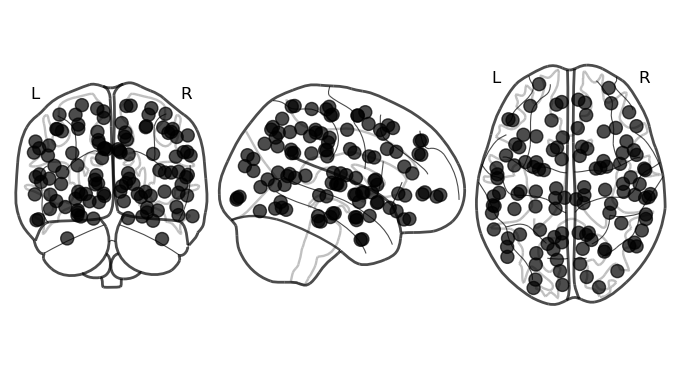

In [197]:
parcellation_fname = 'HarvOxf-sub-Schaefer100-combined-2mm_4d_ds8.nii.gz'

# plot centre of mass for each parcel
p = parcellation.plot_parcellation(parcellation_fname)

### Compute Parcel Time-courses

We use this parcellation to compute the parcel time courses using the parcellation and the dipole time courses. Note that the output parcel timepoints includes all time points, including any bad time segments.

Let's now parcellate the data to compute parcel time courses. This is done using the "spatial_basis" method, where the parcel time-course 
first principal component from all voxels, weighted by the spatial map for the parcel.

In [198]:
print("Parcellating data")

# Apply parcellation to (voxels x all_tpts) data contained in recon_timeseries_mni.
# The resulting parcel_timeseries will be (parcels x all_tpts) in MNI space
# where all_tpts includes bad time segments
parcel_ts, _, _ = parcellation.parcellate_timeseries(
    parcellation_fname, # corresponds to the -beamform_and_parcellate: method: parcellation_file
    recon_timeseries_mni, # reconstructed timeseries in MNI space; dimensions are (dipoles x all_tpts)
    recon_coords_mni,  # dimensions are 3 x dipoles ((3, 2527)). the 3 rows are x, y, and z coordinates in MNI space
    "spatial_basis",  # corresponds to the -beamform_and_parcellate: method: setting
    recon_dir,
)

print("Completed")
print("Dimensions of parcel timeseries in MNI space is (nparcels x all_tpts) = {}".format(parcel_ts.shape))

Parcellating data
 gridstep = 10 mm


Completed
Dimensions of parcel timeseries in MNI space is (nparcels x all_tpts) = (114, 812300)


Now put parcel time courses into a new MNE raw object `parc_raw`, so that working with the data later in MNE is easier.

In [199]:
# Create mne raw object for the parcellated data

# We reload raw data to ensure that the stim channel is in there
raw = mne.io.read_raw_fif(fif_files[1]) # recall that fif_files[1] is sub 17 run 1

parc_raw = parcellation.convert2mne_raw(parcel_ts, raw)

print("Dimensions of parc_raw are (nparcels x all_tpts) = {}".format(parc_raw.get_data().shape))

Dimensions of parc_raw are (nparcels x all_tpts) = (115, 858000)


In [200]:
src_dir = op.join(coinsmeg.DERIVATIVES_DIR, "src", sub) # directory for saving source reconstructed files
os.makedirs(src_dir, exist_ok=True)

# save parc_raw into the src_dir
parc_raw.save(op.join(src_dir, "parc_raw.fif"), overwrite=True)

# Epoching

In [201]:
from osl import preprocessing

dataset = preprocessing.read_dataset(fif_files[1], ftype = "preproc_raw") 
# ftype shows the ending that was replaced by event-id, events, etc
# default was preproc-raw
dataset

Loading dataset:
Reading /ohba/pi/lhunt/datasets/coins-meg_data/derivatives/preprocessed/sub-17_ses-2-meg_task-coinsmeg_run-1_meg_transsss/sub-17_ses-2-meg_task-coinsmeg_run-1_meg_transsss_preproc_raw.fif
Reading /ohba/pi/lhunt/datasets/coins-meg_data/derivatives/preprocessed/sub-17_ses-2-meg_task-coinsmeg_run-1_meg_transsss/sub-17_ses-2-meg_task-coinsmeg_run-1_meg_transsss_events.npy
Reading /ohba/pi/lhunt/datasets/coins-meg_data/derivatives/preprocessed/sub-17_ses-2-meg_task-coinsmeg_run-1_meg_transsss/sub-17_ses-2-meg_task-coinsmeg_run-1_meg_transsss_event-id.yml
Reading /ohba/pi/lhunt/datasets/coins-meg_data/derivatives/preprocessed/sub-17_ses-2-meg_task-coinsmeg_run-1_meg_transsss/sub-17_ses-2-meg_task-coinsmeg_run-1_meg_transsss_ica.fif


{'raw': <Raw | sub-17_ses-2-meg_task-coinsmeg_run-1_meg_transsss_preproc_raw.fif, 331 x 858000 (858.0 s), ~6.5 MB, data not loaded>,
 'events': array([[ 181696,       4,     100],
        [ 186664,       0,     101],
        [ 204240,       0,     102],
        ...,
        [ 999762,       0,       4],
        [1000230,       0,      20],
        [1008966,       0,     105]]),
 'event_id': {'blockEnd': 20,
  'blockStart': 10,
  'expEnd': 105,
  'expStart': 100,
  'keyDown': 6,
  'keyLeft': 4,
  'keyRelease': 7,
  'keyRight': 3,
  'keyUp': 5,
  'laserHit': 1,
  'laserMiss': 2},
 'epochs': None,
 'ica': <ICA | raw data decomposition, method: fastica (fit in 80 iterations on 812300 samples), 64 ICA components (306 PCA components available), channel types: mag, grad, 2 sources marked for exclusion>}

In [202]:
epochs = mne.Epochs(
    parc_raw,
    dataset["events"],
    dataset["event_id"],
    tmin=-0.5,
    tmax=1,
    baseline= (0, 0.3),
)

print("Dimensions of epochs are (good_epochs x parcels x tpts_within_epoch) = {}".format(epochs.get_data().shape))


Dimensions of epochs are (good_epochs x parcels x tpts_within_epoch) = (4917, 115, 1501)


Now plot a simple evoked response for this session of data (averaging over ALL epochs) for a selected parcel.

Plotting group COPE time course for parcel: 2


Text(0, 0.5, 'ERF')

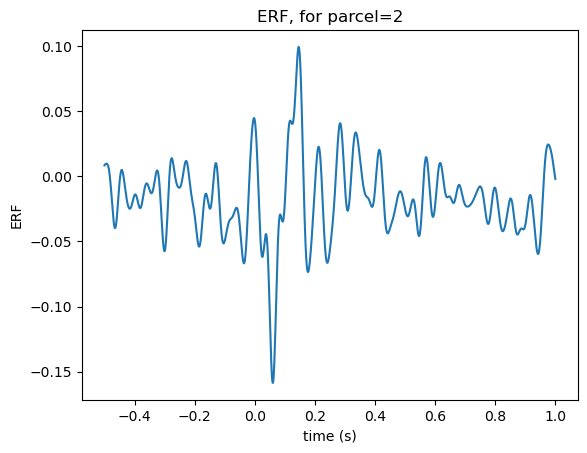

In [203]:
import matplotlib.pyplot as plt
import numpy as np

parcel_ind = 2
print("Plotting group COPE time course for parcel:", parcel_ind)

# average over trials/epochs
erf = np.mean(epochs.get_data()[:, parcel_ind, :], axis=0)

plt.figure()
plt.plot(epochs.times, erf)
plt.title("ERF, for parcel={}".format(parcel_ind))
plt.xlabel("time (s)")
plt.ylabel("ERF")

In [204]:
hit_epochs = epochs["laserHit"]
miss_epochs = epochs["laserMiss"]

In [205]:
hit_epochs

<Epochs |  839 events (all good), -0.5 - 1 sec, baseline 0 – 0.3 sec, ~113 kB, data not loaded,
 'laserHit': 839>

In [206]:
print(hit_epochs.info['ch_names'])

['parcel_0', 'parcel_1', 'parcel_2', 'parcel_3', 'parcel_4', 'parcel_5', 'parcel_6', 'parcel_7', 'parcel_8', 'parcel_9', 'parcel_10', 'parcel_11', 'parcel_12', 'parcel_13', 'parcel_14', 'parcel_15', 'parcel_16', 'parcel_17', 'parcel_18', 'parcel_19', 'parcel_20', 'parcel_21', 'parcel_22', 'parcel_23', 'parcel_24', 'parcel_25', 'parcel_26', 'parcel_27', 'parcel_28', 'parcel_29', 'parcel_30', 'parcel_31', 'parcel_32', 'parcel_33', 'parcel_34', 'parcel_35', 'parcel_36', 'parcel_37', 'parcel_38', 'parcel_39', 'parcel_40', 'parcel_41', 'parcel_42', 'parcel_43', 'parcel_44', 'parcel_45', 'parcel_46', 'parcel_47', 'parcel_48', 'parcel_49', 'parcel_50', 'parcel_51', 'parcel_52', 'parcel_53', 'parcel_54', 'parcel_55', 'parcel_56', 'parcel_57', 'parcel_58', 'parcel_59', 'parcel_60', 'parcel_61', 'parcel_62', 'parcel_63', 'parcel_64', 'parcel_65', 'parcel_66', 'parcel_67', 'parcel_68', 'parcel_69', 'parcel_70', 'parcel_71', 'parcel_72', 'parcel_73', 'parcel_74', 'parcel_75', 'parcel_76', 'parcel_

In [207]:
evoked_hit = hit_epochs.average(picks = parcel_ind)
evoked_hit

<Evoked | 'laserHit' (average, N=839), -0.5 – 1 sec, baseline 0 – 0.3 sec, 1 ch, ~19 kB>

In [208]:
evoked_miss = miss_epochs.average(picks = parcel_ind)
evoked_miss

<Evoked | 'laserMiss' (average, N=291), -0.5 – 1 sec, baseline 0 – 0.3 sec, 1 ch, ~19 kB>

In [209]:
print(evoked_hit.info)

<Info | 9 non-empty values
 bads: []
 ch_names: parcel_2
 chs: 1 misc
 custom_ref_applied: False
 description: TRIUX system at OHBA-3143 OSL BATCH PROCESSING APPLIED ON ...
 dig: 0 items
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: 2023-05-12 09:56:56 UTC
 nchan: 1
 projs: []
 sfreq: 1000.0 Hz
>


/tmp/ipykernel_415010/546323318.py:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds([evoked_hit, evoked_miss], picks="parcel_2",


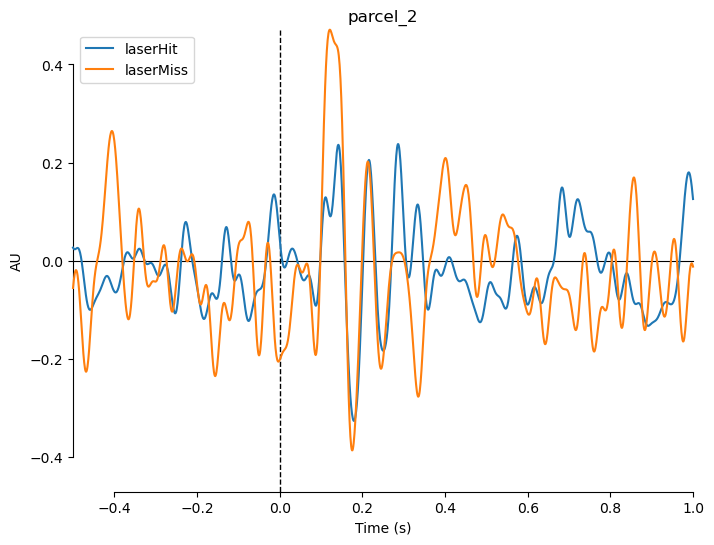

[<Figure size 800x600 with 1 Axes>]

In [210]:
## Compare hit vs miss evokeds, global field power

mne.viz.plot_compare_evokeds([evoked_hit, evoked_miss], picks="parcel_2",
                             show_sensors='upper right')